<a href="https://colab.research.google.com/github/Khuliso877/Week-7-AI/blob/main/Audit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install aif360
!pip install 'aif360[all]'
!pip install seaborn scikit-learn pandas numpy matplotlib

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from aif360.datasets import CompasDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing

from sklearn.linear_model import LogisticRegression

/usr/local/lib/python3.12/dist-packages/inFairness/utils/ndcg.py:37: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  vect_normalized_discounted_cumulative_gain = vmap(
/usr/local/lib/python3.12/dist-packages/inFairness/utils/ndcg.py:48: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  monte_carlo_vect_ndcg = vmap(vect_normalized_discounted

In [4]:
dataset = CompasDataset()

# Define privileged and unprivileged groups
privileged = [{'race': 1}]       # White
unprivileged = [{'race': 0}]     # African-American

dataset

               instance weights            features                            \
                                protected attribute       protected attribute   
                                                sex   age                race   
instance names                                                                  
1                           1.0                 0.0  69.0                 0.0   
3                           1.0                 0.0  34.0                 0.0   
4                           1.0                 0.0  24.0                 0.0   
7                           1.0                 0.0  44.0                 0.0   
8                           1.0                 0.0  41.0                 1.0   
...                         ...                 ...   ...                 ...   
10996                       1.0                 0.0  23.0                 0.0   
10997                       1.0                 0.0  23.0                 0.0   
10999                       

In [5]:
import os
import requests

# Define the target directory and file path
data_dir = '/usr/local/lib/python3.12/dist-packages/aif360/data/raw/compas'
file_path = os.path.join(data_dir, 'compas-scores-two-years.csv')
file_url = 'https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv'

# Create the directory if it doesn't exist
os.makedirs(data_dir, exist_ok=True)

# Download the file if it doesn't exist
if not os.path.exists(file_path):
    print(f"Downloading {file_url} to {file_path}...")
    response = requests.get(file_url)
    response.raise_for_status() # Raise an exception for HTTP errors
    with open(file_path, 'wb') as f:
        f.write(response.content)
    print("Download complete.")
else:
    print(f"File already exists at {file_path}.")

File already exists at /usr/local/lib/python3.12/dist-packages/aif360/data/raw/compas/compas-scores-two-years.csv.


In [6]:
metric = BinaryLabelDatasetMetric(
    dataset,
    privileged_groups=privileged,
    unprivileged_groups=unprivileged
)

print("### Dataset Bias Metrics ###")
print("Mean Difference:", metric.mean_difference())
print("Disparate Impact:", metric.disparate_impact())

### Dataset Bias Metrics ###
Mean Difference: -0.09713793951315464
Disparate Impact: 0.8403836674666473


In [7]:
# Split into train/test
dataset_train, dataset_test = dataset.split([0.7], shuffle=True)

# Extract train features and labels
X_train = dataset_train.features
y_train = dataset_train.labels.ravel()

clf = LogisticRegression(max_iter=2000)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(dataset_test.features)
dataset_test_pred = dataset_test.copy()
dataset_test_pred.labels = y_pred

In [8]:
classification_metric = ClassificationMetric(
    dataset_test,
    dataset_test_pred,
    privileged_groups=privileged,
    unprivileged_groups=unprivileged
)

fpr_priv = classification_metric.false_positive_rate(privileged=True)
fpr_unpriv = classification_metric.false_positive_rate(privileged=False)

print("### Baseline Model Bias ###")
print("False Positive Rate (Privileged - White):", fpr_priv)
print("False Positive Rate (Unprivileged - Black):", fpr_unpriv)

### Baseline Model Bias ###
False Positive Rate (Privileged - White): 0.6220472440944882
False Positive Rate (Unprivileged - Black): 0.3613861386138614


/tmp/ipython-input-2025609698.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


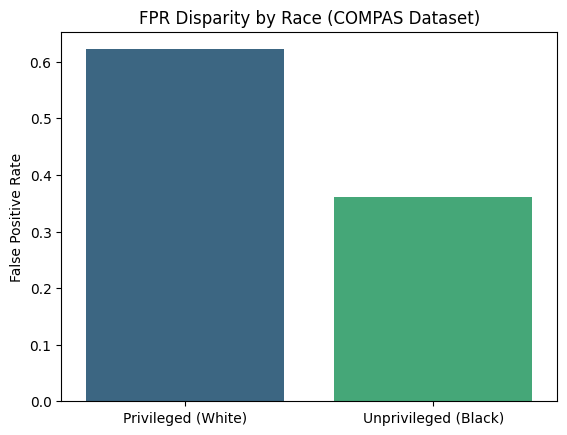

In [9]:
sns.barplot(
    x=["Privileged (White)", "Unprivileged (Black)"],
    y=[fpr_priv, fpr_unpriv],
    palette="viridis"
)
plt.ylabel("False Positive Rate")
plt.title("FPR Disparity by Race (COMPAS Dataset)")
plt.show()

In [10]:
# Apply reweighing
RW = Reweighing(
    privileged_groups=privileged,
    unprivileged_groups=unprivileged
)
dataset_train_rw = RW.fit_transform(dataset_train)

# Train logistic regression on reweighed data
clf_rw = LogisticRegression(max_iter=2000)
clf_rw.fit(
    dataset_train_rw.features,
    dataset_train_rw.labels.ravel(),
    sample_weight=dataset_train_rw.instance_weights
)

# Predict on test data
y_pred_rw = clf_rw.predict(dataset_test.features)
dataset_test_pred_rw = dataset_test.copy()
dataset_test_pred_rw.labels = y_pred_rw

In [11]:
classification_metric_rw = ClassificationMetric(
    dataset_test,
    dataset_test_pred_rw,
    privileged_groups=privileged,
    unprivileged_groups=unprivileged
)

print("### Post-Mitigation Metrics ###")
print("FPR (Privileged - White):", classification_metric_rw.false_positive_rate(privileged=True))
print("FPR (Unprivileged - Black):", classification_metric_rw.false_positive_rate(privileged=False))

### Post-Mitigation Metrics ###
FPR (Privileged - White): 0.468503937007874
FPR (Unprivileged - Black): 0.42244224422442245
